# This notebook is meant to create functions for plotting 

Goal is then to add them to the classes or to use to check that everything is well

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import joint_distrib
from tempest import handler
from tempest import storm_tracker

settings_path = 'settings/tropics.yaml'

## Load instances

In [3]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, verbose = False)
gr = grid.Grid(cs, verbose = False, overwrite = False)
# jd = joint_distrib.JointDistribution(gr)


Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/grid_attributes.pkl instead of computing


In [5]:
if __name__ == '__main__':
    st = storm_tracker.StormTracker(gr, overwrite = False) #overwrite = True is super long
    # st_feng = storm_tracker.StormTracker(gr, label_var_id = "MCS_label_Tb_Feng", overwrite = False)
    pass


Loading storms...
/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-SAM-20160801-20160831.dat.gz
/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-SAM-20160901-20160910.dat.gz
Time elapsed for loading storms: 98.88 seconds


In [6]:
jd = joint_distrib.JointDistribution(gr, st, nd=5)
# jd_feng = joint_distrib.JointDistribution(gr, st_feng, nd=5)

Distribs loaded
Overwrite set to false so loading basics attributes from .npy
Time elapsed for propagating all labels: 13.17 seconds


## Test one snapshot

In [25]:
i_label = 200
storm = jd.storms[i_label]

lifecycle = storm.clusters
utc_0, utc_f = storm.Utime_Init, storm.Utime_End
i_0, i_f = int(utc_0/30), int(utc_f/30) # roots
print("storm label", storm.label,  "from", i_0, "to" ,i_f)

### Make it square

length = max(storm.latmin%90 - storm.latmax%90, storm.lonmax - storm.lonmin)
bordersize = 2
i_t = i_0 + 8

if np.isclose(storm.latmax - storm.latmin, length):
    latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
    lonmid = (storm.lonmin + storm.lonmax) / 2
    lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
else : 
    latmid = (storm.lonmin + storm.lonmax) / 2
    latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
    lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
    
print(length)
print("longitude min and max", lonmin, lonmax)
print("latitude min and max", latmin, latmax)

def _load_plot_var(var_id, gr, i_t):

    if var_id == "MCS_label" or var_id == "MCS_label_Tb_Feng":
        var= hdlr.load_var(gr, var_id, i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
        n_lat, n_lon = var.shape
        n = min(var.shape)
    else : 
        var = hdlr.load_var(gr, var_id, i_t).sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :]
        n_lat, n_lon = var.shape
        n = min(var.shape)
         # approximate square
    var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square
    return var


storm label 206 from 28 to 47
0.8100000000000023
longitude min and max 115.37 120.18
latitude min and max 10.325 15.845


In [26]:
clusters = storm.clusters
print(len(clusters.Utime))
storm

20


< MCS_IntParameters object:
 . label: 206
 . qc_MCS: 11100
 . duration: 10.0
 . classif: 2
 . Tmax: 0.0
 . Utime_Init: 840.0
 . lonInit: 118.16
 . latInit: 12.79
 . Utime_End: 1410.0
 . lonEnd: 117.37
 . latEnd: 13.4
 . lonmin: 117.37
 . latmin: 12.73
 . lonmax: 118.18
 . latmax: 13.44
 . vavg: 3.04
 . dist: 109.4
 . olrmin: 190.0
 . surfmaxPix_172Wm2: 0
 . surfmaxkm2_172Wm2: 36997.0
 . surfmaxkm2_132Wm2: 32973.37
 . surfmaxkm2_110Wm2: 25282.57
 . surfmaxkm2_90Wm2: 14950.35
 . surfcumkm2_172Wm2: 316179.22
 . surfcumkm2_132Wm2: 0
 . surfcumkm2_110Wm2: 0
 . surfcumkm2_90Wm2: 0
 . precip_total: 0
 . precip_max: 0
 . maxSurf00mmh_km2: 0
 . maxSurf02mmh_km2: 0
 . maxSurf05mmh_km2: 0
 . maxSurf10mmh_km2: 0
 . classif_JIRAK: 0.0
 . localtime_Init: 1312.0
 . localtime_End: 1879.0
 . clusters: <class 'tempest.load_toocan.MCS_Lifecycle'>
 >

In [28]:
i = i_t - i_0 - 1 # weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]
var_id = "Prec"
var_unit = "mm/h"
var_cmap = "Blues"
var = _load_plot_var(var_id, gr, i_t)
olr = _load_plot_var("LWNTA", gr, i_t)
seg = _load_plot_var("MCS_label", gr, i_t)
np.unique(seg)

array([   31.,    33.,    39.,   202.,   206.,   221.,   605.,   609.,
         628.,   657.,   689.,  1363.,  1404.,  3879.,  4090.,  5267.,
        6828.,  6958.,  8614., 10388., 12214.,    nan], dtype=float32)

In [23]:
# ## winds 
# u, v = hdlr.load_var(gr, "U10m", i_t), hdlr.load_var(gr, "V10m", i_t)
# u, v = u.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :], v.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] 
# u, v = u[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2].values, v[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2].values

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


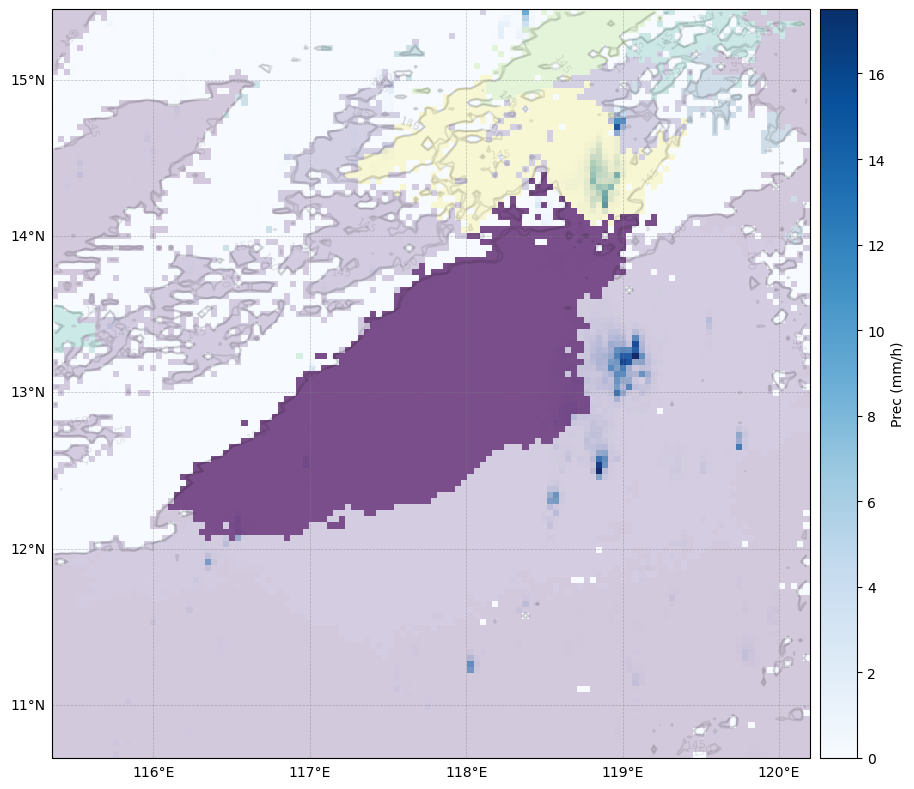

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

cloud_mask = (seg.astype(int) == storm.label)
# Set alpha values for clouds based on the mask
alpha_values = np.where(cloud_mask, 0.7, 0.2)

fig, ax = plt.subplots(subplot_kw=dict(projection = ccrs.PlateCarree(central_longitude = lonmax + lonmin / 2)), figsize=(10, 8))
lon, lat = seg.longitude.values, seg.latitude.values

# Define contour levels
contour_levels = np.arange(145, 155, 5)

# Plot contours with specified levels
contour_plot = ax.contour(lon, lat, olr, transform=ccrs.PlateCarree(), levels=contour_levels, colors='k', alpha=0.1)

# Add contour labels
contour_labels = plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%1.0f')


p = ax.pcolormesh(lon, lat, var, cmap=var_cmap, transform=ccrs.PlateCarree())

c = ax.pcolormesh(lon, lat, seg,  transform=ccrs.PlateCarree(), cmap="viridis", alpha=alpha_values) 



# w = ax.quiver(lon, lat, u, v, transform=ccrs.PlateCarree(), regrid_shape = 50)
# ax.coastlines()

# Adding gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
loc_interval = 1
gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
gl.top_labels = False  # Turn off labels on the top x-axis
gl.right_labels = False  # Turn off labels on the right y-axis
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Create colorbar in a separate axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
label_name = f'{var_id} ({var_unit})'  # Use actual variable name
cbar = plt.colorbar(p, cax=cax, orientation='vertical', label=label_name)


# Adjust layout for the colorbars
# fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

plt.tight_layout()
# Save the figure if needed
# plt.savefig(path_stamp)

plt.show()

## Saves snapshots in cache of settings

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

verbose = False

# i_label = 20000
label = 273838
i_label = jd.dict_i_storms_by_label[label]
storm = jd.storms[i_label]
label = storm.label

lifecycle = storm.clusters
utc_0, utc_f = storm.Utime_Init, storm.Utime_End
i_0, i_f = int(utc_0/30), int(utc_f/30) # roots
print("storm label", storm.label,  "from", i_0, "to" ,i_f)

### Make it square

length = max(storm.latmin%90 - storm.latmax%90, storm.lonmax - storm.lonmin)
bordersize = 2
i_t = i_0 + 8

if np.isclose(storm.latmax - storm.latmin, length):
    latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
    lonmid = (storm.lonmin + storm.lonmax) / 2
    lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
else : 
    latmid = (storm.lonmin + storm.lonmax) / 2
    latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
    lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
    
print(length)
print("longitude min and max", lonmin, lonmax)
print("latitude min and max", latmin, latmax)
    
var_id = "Prec"
var_unit = "mm/h"
var_cmap = "Blues"
    
for i_t in range(i_0, i_f):

    var = _load_plot_var(var_id, gr, i_t)
    olr = _load_plot_var("LWNTA", gr, i_t)
    seg = _load_plot_var("MCS_label", gr, i_t)
    # # winds
    # u, v = hdlr.load_var(gr, "U10m", i_t), hdlr.load_var(gr, "V10m", i_t)
        
    cloud_mask = (seg.astype(int) == storm.label)
    # Set alpha values for clouds based on the mask
    alpha_values = np.where(cloud_mask, 0.7, 0.2)

    fig, ax = plt.subplots(subplot_kw=dict(projection = ccrs.PlateCarree(central_longitude = lonmax + lonmin / 2)), figsize=(10, 8))
    lon, lat = seg.longitude.values, seg.latitude.values

    # Define contour levels
    contour_levels = np.arange(130, 165, 15) #225K to 236K

    # Plot contours with specified levels
    contour_plot = ax.contour(lon, lat, olr, transform=ccrs.PlateCarree(), levels=contour_levels, colors='k', alpha=0.1)

    # Add contour labels
    contour_labels = plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%1.0f')
    # plot precip (p)
    p = ax.pcolormesh(lon, lat, var, cmap=var_cmap, transform=ccrs.PlateCarree())
    # plot clouds (c)
    c = ax.pcolormesh(lon, lat, seg,  transform=ccrs.PlateCarree(), cmap="viridis", alpha=alpha_values) 
    # plot winds (w)
    # w = ax.quiver(lon, lat, u, v, transform=ccrs.PlateCarree(), regrid_shape = 50)
    ax.coastlines()

    # Adding gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    loc_interval = 1
    gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
    gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
    gl.top_labels = False  # Turn off labels on the top x-axis
    gl.right_labels = False  # Turn off labels on the right y-axis
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Create colorbar in a separate axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    label_name = f'{var_id} ({var_unit})'  # Use actual variable name
    cbar = plt.colorbar(p, cax=cax, orientation='vertical', label=label_name)


    # Adjust layout for the colorbars
    fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

    plt.tight_layout() 
    # saving frames and making dirs in cache
    cache = os.path.join(cs.settings["DIR_TEMPDATA"], cs.name)

    if not os.path.exists(cache):
        os.makedirs(cache)
        print("Could be made at class level")

    figname = f"storm_{label}_{var_id}" #maybe show a better date than it here but will do
    dir_path = os.path.join(cache, figname)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"made {dir_path}, don't forget to delete")

    stamp = f"{i_t}".zfill(5)
    path_stamp = os.path.join(dir_path, stamp)
    plt.savefig(path_stamp)
    print(f"Timestamp {i_t} saved")
    plt.close(fig)
    

storm label 273838 from 1614 to 1651
1.6700000000000017
longitude min and max 122.13 127.8
latitude min and max 7.824999999999999 14.015


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


made /scratchx/mcarenso/tempest/DYAMOND_SAM_Tropics/storm_273838_Prec, don't forget to delete
Timestamp 1614 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1615 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1616 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1617 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1618 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1619 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1620 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1621 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1622 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1623 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1624 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1625 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Timestamp 1626 saved


In [34]:
# def tb_from_olr(olr):
#     a= 1.228
#     b=-1.106e-3
#     sigma = 5.67e-8
#     tf = (olr/sigma)**0.25
#     Tb= (-a +np.sqrt(a**2 +4*b*tf))/(2*b)
#     return Tb
# tb_from_olr(160)

# Makes video and del cache

In [58]:
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Output video file name
output_file = f"/home/mcarenso/code/tempest/figures/{label}.mp4"

# List all PNG files in the input directory
image_files = [file for file in os.listdir(dir_path) if file.endswith('.png')]
image_files.sort()  # Ensure sorted order

# Create a list to store image paths
image_paths = [os.path.join(dir_path, file) for file in image_files]

# Function to update the figure for each frame
def update_figure(i):
    img = plt.imread(image_paths[i])
    im.set_array(img)
    return [im]

# Create the video using Matplotlib's animation module
fig, ax = plt.subplots()
im = ax.imshow(plt.imread(image_paths[0]))

# You can customize other animation parameters such as interval, repeat, etc.
animation = animation.FuncAnimation(fig, update_figure, frames=len(image_paths), interval=500, blit=True)

animation.save(output_file, writer='ffmpeg', fps=1, dpi=300)

# Display the animation in the notebook
HTML(animation.to_jshtml())
plt.close(fig)

for path in image_paths:
    os.remove(path)

# Vanilla Multiple data


In [ ]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

verbose = False

label = 353
storm = jd.storms[label]
lifecycle = storm.clusters

utc_0, utc_f = storm.Utime_Init, storm.Utime_End
#carefull here, we remove and add 1 as to see better the conditions of genesis and dissipation
i_0, i_f = hdlr.i_t_from_utc(utc_0)-1, hdlr.i_t_from_utc(utc_f)+1

var_id = "Prec"
var_unit = "mm/h"
var_cmap = jd.settings["cmap_specs"]["prec"]

for i_t in range(i_0, i_f):
    
    length = max(storm.latmax - storm.latmin, storm.lonmax - storm.lonmin)
    bordersize = 2

    # Build the square
    if np.isclose(storm.latmax - storm.latmin, length):
        latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
        lonmid = (storm.lonmin + storm.lonmax) / 2
        lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
    else : 
        latmid = (storm.lonmin + storm.lonmax) / 2
        latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
        lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
        
    if verbose : print(lonmin, lonmax, latmin, latmax)

    seg = hdlr.load_seg(gr, i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
    n_lat, n_lon = seg.shape
    n = min(seg.shape)
    seg = seg[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2]
    
    #relative index to i_0, used to catch data from the lifecycle lists of the storm
    i = i_t - i_0 - 1 #weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
    cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]

    var_ids = ["Prec", "PW", "T2mm", "Q2m"]
    var_units = ["mm/h", "mm", "K", "?"]
    var_cmaps = ["ocean_r", "Blues", "RdBu_r", "RdBu"]
    vars = []
    for var_id in var_ids:
        var = hdlr.load_var(gr, var_id, i_t)
        var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] # approximate square
        var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square
        vars.append(var)
        print(f"{var_id} loaded ;", end ='\t')
    
    
        # Assuming 'seg' is your array with cloud labels
    # Create a mask to identify the clouds with a specific label
    cloud_mask = (seg == storm.label)

    # Set alpha values for clouds based on the mask
    alpha_values = np.where(cloud_mask, 0.7, 0.2)

    fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(20, 16))

    # Assuming var1, var2, var3, and var4 are your different variables
    var_list = vars

    for ax, var, var_id, unit, cmap in zip(axes.flatten(), var_list, var_ids, var_units, var_cmaps):
        # Set latitude and longitude ticks
        v = ax.pcolormesh(seg.longitude, seg.latitude, var, cmap=cmap, shading='auto', transform=ccrs.PlateCarree())

        c = ax.pcolormesh(seg.longitude, seg.latitude, seg, transform=ccrs.PlateCarree(), cmap='viridis', alpha=alpha_values)

        ax.coastlines()

        # Adding gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        loc_interval = 1
        gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
        gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
        gl.top_labels = False  # Turn off labels on the top x-axis
        gl.right_labels = False  # Turn off labels on the right y-axis
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        # Create colorbar in a separate axis
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
        label_name = f'{var_id} ({unit})'  # Use actual variable name
        cbar = plt.colorbar(v, cax=cax, orientation='vertical', label=label_name)

        # Set the projection for the colorbar axis
        # cax.set_projection(ccrs.PlateCarree())

    # Adjust layout for the colorbars
    fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

    plt.tight_layout()

    # saving frames and making dirs in cache
    cache = os.path.join(cs.settings["DIR_TEMPDATA"], cs.name)

    if not os.path.exists(cache):
        os.makedirs(cache)
        print("Could be made at class level")

    figname = f"storm_{label}" #maybe show a better date than it here but will do
    dir_path = os.path.join(cache, figname)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"made {dir_path}, don't forget to delete")

    stamp = f"{i_t}"
    path_stamp = os.path.join(dir_path, stamp)
    plt.savefig(path_stamp)
    print(f"Timestamp {i_t} saved")
    plt.close(fig)
            